<a href="https://colab.research.google.com/github/paulokj/deploying-machine-learning-models/blob/master/CS_JokeRatingPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr>

# **Jokes Rating Prediction**

**Author: Intellipaat**

**Link for the dataset: https://www.kaggle.com/datasets/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset/download?datasetVersionNumber=3**

<hr>

# **Problem Statement**

**Online stores and entertainment platforms like Netflix depend heavily on what customers think. Reviews and ratings are crucial for these businesses, especially when recommending products or content. Netflix uses ratings to suggest movies and shows that each user is likely to enjoy based on what they've liked before.**

**This task involves predicting how users would rate a new group of jokes, considering how they rated other jokes in the past. The data comes from a popular joke recommendation system called Jester.**

<hr>

# **Content**
  * **The dataset contains over 1.7 million continuous ratings (-10.00 to +10.00) of 150 jokes from 59,132 users.**
  * **The dataset is collected between November 2006 - May 2009.**
  * **The complete dataset has two CSV files:-**
    * **jester_ratings.csv: Each row is formatted as [User ID] [Item ID] [Rating]**
    * **jester_items.csv: Maps item ID's to jokes**

      **The ratings are real values ranging from -10.00 to +10.00.**

<hr>

# **Step 1 - Importing of Libraries**

**1. Configuration Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**2. Mandatory Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**3. Required Libraries**

In [ ]:
from sklearn.metrics import *
from xgboost import XGBClassifier
from nltk.tokenize import RegexpTokenizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

<hr>

# **Step 2 - Data Loading**

**We have two datasets to work on.**

In [ ]:
df_jokes = pd.read_csv('/content/drive/MyDrive/Datasets/Sentimental Analysis/Jokes Prediction Data/jester_items.csv')

**Dataset having all the jokes**

In [ ]:
df_jokes.head().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I have bad news for you.You have cancer and Alzheimer's disease"". The man replies ""Well,thank God I don't have cancer!"""
1,2,"This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him. ""What could they possibly have said to make you move out?"" ""They told me that you were a pedophile."" He replied, ""That's an awfully big word for a ten year old."""
2,3,Q. What's 200 feet long and has 4 teeth? A. The front row at a Willie Nelson Concert.
3,4,Q. What's the difference between a man and a toilet? A. A toilet doesn't follow you around after you use it.
4,5,"Q. What's O. J. Simpson's Internet address? A. Slash, slash, backslash, slash, slash, escape."


**Shape Inspection**

In [ ]:
df_jokes.shape

(150, 2)

<hr>

**Unique values**

In [ ]:
df_jokes['jokeId'].nunique()

150

<hr>

**Information**

In [ ]:
df_jokes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   jokeId    150 non-null    int64 
 1   jokeText  150 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


<hr>

**Dataset having all the rating with the users**

In [ ]:
df_rating = pd.read_csv('/content/drive/MyDrive/Datasets/Sentimental Analysis/Jokes Prediction Data/jester_ratings.csv')

In [ ]:
df_rating.head().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,userId,jokeId,rating
0,1,5,0.219000
1,1,7,-9.281000
2,1,8,-9.281000
3,1,13,-6.781000
4,1,15,0.875000


**Shape Inspection**

In [ ]:
df_rating.shape

(1761439, 3)

<hr>

**Unique values**

In [ ]:
df_rating['jokeId'].nunique()

140

<hr>

**Information**

In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761439 entries, 0 to 1761438
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userId  int64  
 1   jokeId  int64  
 2   rating  float64
dtypes: float64(1), int64(2)
memory usage: 40.3 MB


<hr>

# **Step 3 - Formulation of Approach**

**Here the approach is to combine both the data. Using the Ratings data we would have to grab the average rating for all the jokes present.**

**Step A - Grouping the data**

In [ ]:
a = df_rating.groupby('jokeId')['rating'].sum().reset_index()

In [ ]:
a

,jokeId,rating
0,5,-1160.935
1,7,-106965.294
2,8,-38788.437
3,13,-33249.090
4,15,-75646.752
...,...,...
135,146,875.890
136,147,17348.869
137,148,45889.665
138,149,26323.365


**Here is the first issue since the data we are having seems to have some issue with the jokes Id, so we will dissolve the joke ID that are not there in the previous dataset as compared to this one**

In [ ]:
# Filter df1 based on JokeIDs present in df2
df_jokes = df_jokes[df_jokes['jokeId'].isin(df_rating['jokeId'])].reset_index()

df_jokes

,index,jokeId,jokeText
0,4,5,Q.\tWhat's O. J. Simpson's Internet address? \...
1,6,7,How many feminists does it take to screw in a ...
2,7,8,Q. Did you hear about the dyslexic devil worsh...
3,12,13,They asked the Japanese visitor if they have e...
4,14,15,Q: What did the blind person say when given s...
...,...,...,...
135,145,146,America: 8:00 - Welcome to work! 12:00 - Lunch...
136,146,147,It was the day of the big sale. Rumors of the ...
137,147,148,"Recently a teacher, a garbage collector, and a..."
138,148,149,"A little girl asked her father, ""Daddy? Do all..."


**Reset the index for proper order**

In [ ]:
df_jokes = df_jokes.drop('index', axis = 1)

In [ ]:
df_jokes.head().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,jokeId,jokeText
0,5,"Q. What's O. J. Simpson's Internet address? A. Slash, slash, backslash, slash, slash, escape."
1,7,How many feminists does it take to screw in a light bulb? That's not funny.
2,8,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.
3,13,"They asked the Japanese visitor if they have elections in his country. ""Every Morning"" he answers."
4,15,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?


**Adding the rating to the respective jokes**

In [ ]:
df_jokes['AverageRating'] = a['rating']

<hr>

**Finalize dataset for analysis**

In [ ]:
df_jokes.head().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,jokeId,jokeText,AverageRating
0,5,"Q. What's O. J. Simpson's Internet address? A. Slash, slash, backslash, slash, slash, escape.",-1160.935000
1,7,How many feminists does it take to screw in a light bulb? That's not funny.,-106965.294000
2,8,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.,-38788.437000
3,13,"They asked the Japanese visitor if they have elections in his country. ""Every Morning"" he answers.",-33249.090000
4,15,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?,-75646.752000


<hr>

# **Step 4 - Data Preprocessing**

In [ ]:
df_jokes.isnull().sum().to_frame().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,0
jokeId,0
jokeText,0
AverageRating,0


<hr>

# **Step 5 - Formulation of Sentiments**

**`Strategy`: We would look for the lowest average rating and highest average rating and following the same we would be formulating the three category of sentiments, like Positive, Neutral and Negative**

**a) Describing the data on AverageRating**

In [ ]:
df_jokes['AverageRating'].describe()

count       140.000000
mean      20364.781400
std       29316.603098
min     -106965.294000
25%        1455.641250
50%       16861.956000
75%       39383.961500
max       93754.722000
Name: AverageRating, dtype: float64

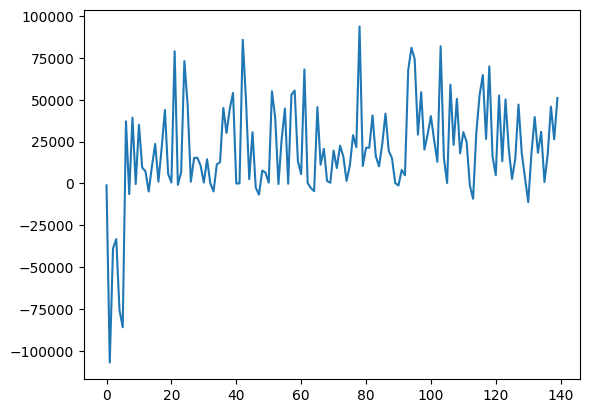

In [ ]:
plt.plot(df_jokes['AverageRating'])

**b) Defining the Range for categorization**

In [ ]:
# Define the cut points for the categories
cuts = [-float('inf'), 0, 50000,float('inf')]

**c) Defining the Categories**

In [ ]:
# Define the labels for the categories
labels = ['Bad','Funny', 'Phenomenal']

**d) Implementing Categories**

In [ ]:
# Categorize the data using cut
categories = pd.cut(df_jokes['AverageRating'], cuts, labels=labels)

**e) Checking the summary**

In [ ]:
# Print the categorized data
print(categories.value_counts())

Funny         96
Bad           22
Phenomenal    22
Name: AverageRating, dtype: int64


**f) Checking the data**

In [ ]:
df_jokes.head().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,jokeId,jokeText,AverageRating
0,5,"Q. What's O. J. Simpson's Internet address? A. Slash, slash, backslash, slash, slash, escape.",-1160.935000
1,7,How many feminists does it take to screw in a light bulb? That's not funny.,-106965.294000
2,8,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.,-38788.437000
3,13,"They asked the Japanese visitor if they have elections in his country. ""Every Morning"" he answers.",-33249.090000
4,15,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?,-75646.752000


**g) Appending the data into the normal dataset**

In [ ]:
df_jokes['Sentiments'] = categories

**h) Checking the data again**

In [ ]:
df_jokes.head().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,jokeId,jokeText,AverageRating,Sentiments
0,5,"Q. What's O. J. Simpson's Internet address? A. Slash, slash, backslash, slash, slash, escape.",-1160.935000,Bad
1,7,How many feminists does it take to screw in a light bulb? That's not funny.,-106965.294000,Bad
2,8,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.,-38788.437000,Bad
3,13,"They asked the Japanese visitor if they have elections in his country. ""Every Morning"" he answers.",-33249.090000,Bad
4,15,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?,-75646.752000,Bad


**i) Encoding the columns as numeric**

In [ ]:
df_jokes['EncodedSentiments'] = df_jokes['Sentiments'].map({
    'Bad':0,
    'Funny':1,
    'Phenomenal':2,
})

**h) Checking the data again**

In [ ]:
df_jokes.head().style.set_properties(
    **{
      'background-color':'black',
      'color':'white',
      'border-color':'white',
      'border-style':'solid'
    }
)

,jokeId,jokeText,AverageRating,Sentiments,EncodedSentiments
0,5,"Q. What's O. J. Simpson's Internet address? A. Slash, slash, backslash, slash, slash, escape.",-1160.935000,Bad,0
1,7,How many feminists does it take to screw in a light bulb? That's not funny.,-106965.294000,Bad,0
2,8,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.,-38788.437000,Bad,0
3,13,"They asked the Japanese visitor if they have elections in his country. ""Every Morning"" he answers.",-33249.090000,Bad,0
4,15,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?,-75646.752000,Bad,0


<hr>

# **Step 6 - Feature Generation using Bag of Words**

**A) Creating the token**

In [ ]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [ ]:
cv = CountVectorizer(lowercase=True, stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

In [ ]:
text_counts= cv.fit_transform(df_jokes['jokeText'])

**B) Training the Model**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(text_counts, df_jokes['EncodedSentiments'], test_size = 0.3, random_state = 42)

**C) Helper Functions for Formulation**

In [ ]:
# Model Function
def ModelBuilding_Evaluation(model, x_train, x_test, y_train, y_test):
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  print(f'Accuracy Score: {accuracy_score(y_test, pred)}')

**D) Implementation of Model**

In [ ]:
# IMPLEMENTING THE DECISION TREE
model = DecisionTreeClassifier()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.6904761904761905


In [ ]:
# IMPLEMENTING THE LOGISTIC REGRESSION
model = LogisticRegression()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.6904761904761905


In [ ]:
# IMPLEMENTING THE RANDOM FOREST
model = RandomForestClassifier()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.7619047619047619


In [ ]:
# IMPLEMENTING THE XGBOOST
model = XGBClassifier()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.6428571428571429


<hr>

# **Step 7 - Using TFID-Vectorizer**

**A) Initializing the TFID-Vectorizer**

In [ ]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df_jokes['jokeText'])

**B) Splitting the data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(text_tf, df_jokes['EncodedSentiments'], test_size = 0.3, random_state = 42)

**C) Model Implementation**

In [ ]:
# IMPLEMENTING THE DECISION TREE
model = DecisionTreeClassifier()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.6666666666666666


In [ ]:
# IMPLEMENTING THE LOGISTIC REGRESSION
model = LogisticRegression()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.7619047619047619


In [ ]:
# IMPLEMENTING THE RANDOM FOREST
model = RandomForestClassifier()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.7619047619047619


In [ ]:
# IMPLEMENTING THE XGBOOST
model = XGBClassifier()
res = ModelBuilding_Evaluation(model,x_train, x_test, y_train, y_test)

Accuracy Score: 0.6428571428571429
